# Example of conversion using data table graphs

In [1]:
from pyMeasure import *
from pyMeasure.Code.DataHandlers.GraphModels import *
import pandas
from ipywidgets import *

Importing Code.Analysis.Fitting
It took 10.147 s to import Code.Analysis.Fitting
Importing Code.Analysis.Interpolation
It took 0.323 s to import Code.Analysis.Interpolation
Importing Code.Analysis.NISTUncertainty
It took 0.02 s to import Code.Analysis.NISTUncertainty
Importing Code.Analysis.SParameter
The module smithplot was not found,please put it on the python path
It took 13.554 s to import Code.Analysis.SParameter
Importing Code.Analysis.Uncertainty
It took 0.008 s to import Code.Analysis.Uncertainty
Importing Code.DataHandlers.GeneralModels
It took 0.008 s to import Code.DataHandlers.GeneralModels
Importing Code.DataHandlers.GraphModels
It took 0.01 s to import Code.DataHandlers.GraphModels
Importing Code.DataHandlers.HTMLModels
It took 0.004 s to import Code.DataHandlers.HTMLModels
Importing Code.DataHandlers.MUFModels
It took 0.005 s to import Code.DataHandlers.MUFModels
Importing Code.DataHandlers.NISTModels
It took 0.004 s to import Code.DataHandlers.NISTModels
Importing Code

In [2]:
def AsciiDataTable_to_DataFrame_dict(AsciiDataTable):
    """Converts an AsciiDataTable to a dictionary of pandas.DataFrame s"""
    output_dict={}
    for element in AsciiDataTable.elements:
        #print("{0} is {1}".format('element',element))
        if AsciiDataTable.__dict__[element]:
            if re.search('header',element,re.IGNORECASE):
                header_table=pandas.DataFrame(AsciiDataTable.header,columns=["Header_Line_Content"])
                output_dict["Header"]=header_table
            # needs to be before data search    
            elif re.search('meta',element,re.IGNORECASE):
                #print("{0} is {1}".format('element',element))
                metadata_table=pandas.DataFrame([[key,value] for key,value in AsciiDataTable.metadata.iteritems()], 
                                columns=["Property","Value"])
                output_dict["Metadata"]=metadata_table    
            elif re.search('data|^meta',element,re.IGNORECASE):
                
                data_table=pandas.DataFrame(AsciiDataTable.data,columns=AsciiDataTable.column_names)
                output_dict["Data"]=data_table
                
            elif re.search('footer',element,re.IGNORECASE):
                footer_table=pandas.DataFrame(AsciiDataTable.footer,columns=["Footer_Line_Content"])
                output_dict["Footer"]=footer_table
                
            elif re.search('comment',element,re.IGNORECASE):
                comments=AsciiDataTable.__dict__[element]
                inline_comments=pandas.DataFrame(comments,columns=["Comment","Line","Location"])
                output_dict["Comments"]=inline_comments
    return output_dict

def DataFrame_dict_to_AsciiDataTable(DataFrame_dict,**options):
    """Given a dictionary of pandas DataFrames returns an AsciiDataTable"""
    defaults={"comment_begin":"!","comment_end":"\n",
             "column_names_begin_token":"!","column_names_end_token":"\n",
              "data_delimiter":"  ","data_table_element_separator":None}
    #defaults={}
    table_options={}
    for key,value in defaults.iteritems():
        table_options[key]=value
    for key,value in options.iteritems():
        table_options[key]=value
    keys=DataFrame_dict.keys()
    for key in keys:
        table_key=key
        if re.search("comments",key,re.IGNORECASE):
            table_key="inline_comments"
            table_options[table_key]=DataFrame_dict[key].as_matrix().tolist()
            
        elif key in ["data","Data"]:
            table_options["column_names"]=DataFrame_dict[key].columns.tolist()
            table_options["column_types"]=map(lambda x: str(x),DataFrame_dict[key].dtypes.tolist())
            table_options["data"]=DataFrame_dict[key].as_matrix().tolist()
            
        elif re.search("footer",key,re.IGNORECASE):
            list_of_lists=DataFrame_dict[key].as_matrix().tolist()
            list_of_strings=[str(row[0]) for row in list_of_lists]
            table_options["footer"]=list_of_strings
            
        elif re.search("header",key,re.IGNORECASE):
            table_options["treat_header_as_comment"]=True
            list_of_lists=DataFrame_dict[key].as_matrix().tolist()
            list_of_strings=[str(row[0]) for row in list_of_lists]
            #print("{0} is {1}".format("list_of_lists",list_of_lists))
            table_options["header"]=list_of_strings
            
        elif re.search("meta",key,re.IGNORECASE):
            list_of_lists=DataFrame_dict[key].as_matrix().tolist()
            dictionary={str(row[0]):str(row[1]) for row in list_of_lists}
            table_options["metadata"]=dictionary            

    new_table=AsciiDataTable(None,**table_options)
    return new_table
def DataFrame_dict_to_excel(DataFrame_dict,excel_file_name="Test.xlsx"):
    """Converts a dictionary of pandas DataFrames to a single excel file with sheet names
    determined by keys"""
    # sort the keys so that they will display in the same order
    writer = pandas.ExcelWriter(excel_file_name)
    keys=sorted(DataFrame_dict.keys())
    for key in keys:
        #print key
        DataFrame_dict[key].to_excel(writer,sheet_name=key,index=False)
    writer.close()
    return excel_file_name

def excel_to_DataFrame_dict(excel_file_name):
    """Reads an excel file into a dictionary of data frames"""
    data_frame_dictionary=pandas.read_excel(excel_file_name,sheetname=None)
    return data_frame_dictionary

def DataFrame_dict_to_hdf(DataFrame_dict,hdf_file_name="Test.hd5"):
    """Transforms a dictionary of pandas.DataFrames to a single HD5 file with groups determined by the keys"""
    keys=sorted(DataFrame_dict.keys())
    for key in keys:
        DataFrame_dict[key].to_hdf(hdf_file_name,key)
    print("{0} is {1}".format('key',key))
    return hdf_file_name

def hdf_to_DataFrame_dict(hdf_file_name):
    """Creates a dictionary of pandas.DataFrames given a hd5 file name, does this require the table names?
    """
    hdf=h5py.File(hdf_file_name)
    keys=hdf.keys()
    pandas_dictionary={key:pandas.read_hdf(hdf_file_name,key) for key in keys}
    return pandas_dictionary

def AsciiDataTable_to_csv(ascii_data_table,file_name="test.csv",schema_file_name="schema_csv"):
    """Converts an AsciiDataTable into an csv file by setting options and saving"""
    original_options=ascii_data_table.options.copy()
    ascii_data_table.options["column_names_begin_token"]=""
    ascii_data_table.options["column_names_end_token"]="\n"
    ascii_data_table.options["data_table_element_separator"]=None
    ascii_data_table.options["data_begin_token"]=None
    ascii_data_table.options["data_end_token"]=None
    ascii_data_table.options["data_delimiter"]=","
    ascii_data_table.options["column_names_delimiter"]=","
    if ascii_data_table.header is not None:
        ascii_data_table.options["comment_begin"]="#"
        ascii_data_table.options["comment_end"]="\n"
        ascii_data_table.options["treat_header_as_comment"]=True
    if ascii_data_table.footer is not None:
        ascii_data_table.options["comment_begin"]="#"
        ascii_data_table.options["comment_end"]="\n"       
        ascii_data_table.options["treat_footer_as_comment"]=True
    #ascii_data_table.update_model()
    ascii_data_table.save_schema(schema_file_name)
    ascii_data_table.save(file_name)
    ascii_data_table.options=original_options
    return [file_name,schema_file_name]

def AsciiDataTable_to_hp(ascii_data_table,file_name="test.txt",schema_file_name="schema_hp"):
    """Converts an AsciiDataTable into an csv file by setting options and saving"""
    original_options=ascii_data_table.options.copy()
    ascii_data_table.options["column_names_begin_token"]="!"
    ascii_data_table.options["column_names_end_token"]="\n"
    ascii_data_table.options["data_table_element_separator"]=None
    ascii_data_table.options["data_begin_token"]=None
    ascii_data_table.options["data_end_token"]=None
    ascii_data_table.options["data_delimiter"]="  "
    ascii_data_table.options["column_names_delimiter"]="  "
    if ascii_data_table.header is not None:
        ascii_data_table.options["comment_begin"]="!"
        ascii_data_table.options["comment_end"]="\n"
        ascii_data_table.options["treat_header_as_comment"]=True
    if ascii_data_table.footer is not None:
        ascii_data_table.options["comment_begin"]="!"
        ascii_data_table.options["comment_end"]="\n"
        #ascii_data_table.options["treat_header_as_comment"]=True
        ascii_data_table.options["treat_footer_as_comment"]=True
    #ascii_data_table.update_model()
    ascii_data_table.save_schema(schema_file_name)
    ascii_data_table.save(file_name)
    ascii_data_table.options=original_options
    return [file_name,schema_file_name]

def file_to_AsciiDataTable(paths):
    [file_name,schema]=paths
    options=read_schema(schema)
    table=AsciiDataTable(file_name,**options)
    print table
    return table
    
def AsciiDataTable_to_file(ascii_data_table,file_name="Test.txt",schema_file_name="schema"):
    paths=[file_name,schema_file_name]
    ascii_data_table.save(file_name)
    ascii_data_table.save_schema(schema_file_name)
    return paths    


In [3]:
options={}
options["data"]=[[1,2,3],[4,5,6]]
options["column_names"]=['a','b','c']
table=AsciiDataTable(None,**options)
#table=OnePortCalrepModel(os.path.join(TESTS_DIRECTORY,'700437.asc'))
table=TwoPortRawModel(os.path.join(TESTS_DIRECTORY,'TestFileTwoPortRaw.txt'))
#table=SNP(os.path.join(TESTS_DIRECTORY,'Solution_0.s4p'))
data_frame=AsciiDataTable_to_DataFrame_dict(table)

In [4]:
graph_options={"graph_name":"Data Table Graph",
                  "node_names":['DataFrameDict','AsciiDataTable'],
                  "node_descriptions":["Pandas Data Frame Dictionary","AsciiDataTable"],
                  "current_node":'DataFrameDict',
                  "state":[1,0],
                  "data":data_frame,
                  "edge_2_to_1":AsciiDataTable_to_DataFrame_dict,
                  "edge_1_to_2":DataFrame_dict_to_AsciiDataTable
                 }
data_table_graph=Graph(**graph_options)
# graph_options={"graph_name":"Data Table Graph",
#                   "node_names":['AsciiDataTable','csv'],
#                   "node_descriptions":["AsciiDataTable","csv"],
#                   "current_node":'AsciiDataTable',
#                   "state":[1,0],
#                   "data":table,
#                   "edge_2_to_1":file_to_AsciiDataTable,
#                   "edge_1_to_2":AsciiDataTable_to_csv
#                  }
# data_table_graph=Graph(**graph_options)

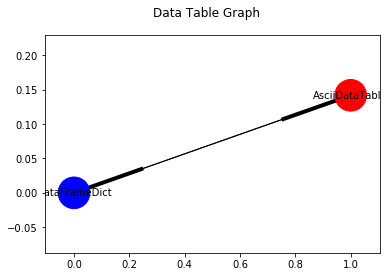

In [5]:
%matplotlib inline
data_table_graph.show()

In [6]:
data_table_graph.add_node("excel","DataFrameDict",DataFrame_dict_to_excel,
                    "DataFrameDict",excel_to_DataFrame_dict,node_description="Excel Workbook")
data_table_graph.add_node("hdf","DataFrameDict",DataFrame_dict_to_hdf,
                    "DataFrameDict",hdf_to_DataFrame_dict,node_description="HD5 File")
data_table_graph.add_node("csv","AsciiDataTable",AsciiDataTable_to_csv,
                    "AsciiDataTable",file_to_AsciiDataTable,node_description="CSV File")
data_table_graph.add_node("hp","AsciiDataTable",AsciiDataTable_to_hp,
                    "AsciiDataTable",file_to_AsciiDataTable,node_description="hp format File")

In [7]:
data_table_graph.move_to_node("AsciiDataTable")

['edge_DataFrameDict_AsciiDataTable_000']
moving DataFrameDict -> AsciiDataTable


In [145]:
print data_table_graph.data.inline_comments

None


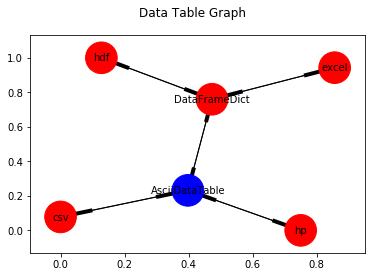

In [8]:
data_table_graph.show()

In [15]:
data_table_graph.is_graph_isomorphic()

['edge_AsciiDataTable_csv_000', 'edge_csv_AsciiDataTable_000']
moving AsciiDataTable -> csv
moving csv -> AsciiDataTable
Warning \n is in the remove tokens
['edge_AsciiDataTable_csv_000']
moving AsciiDataTable -> csv
['edge_csv_AsciiDataTable_000', 'edge_AsciiDataTable_hp_000']
moving csv -> AsciiDataTable
Warning \n is in the remove tokens
moving AsciiDataTable -> hp


True

['edge_AsciiDataTable_DataFrameDict_000', 'edge_DataFrameDict_excel_000']
moving AsciiDataTable -> DataFrameDict
moving DataFrameDict -> excel
********************************************************************************
Excel Workbook [0, 0, 1, 0, 0, 0]
********************************************************************************


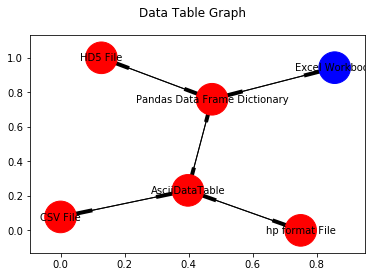

Test.xlsx


In [11]:
%matplotlib inline
history=[]
def move_and_show(end_node_number):
    node=data_table_graph.node_names[end_node_number]
    data_table_graph.move_to_node(node)
    print("*"*80)
    print("{0}".format(data_table_graph.node_descriptions[end_node_number])+" {0}".format(data_table_graph.state))
    print("*"*80)
    data_table_graph.show(descriptions=True)
    print data_table_graph.data
    history.append(node)
    
interact(move_and_show,end_node_number=(0,len(data_table_graph.node_names)-1,1))

In [10]:
#test_table=file_to_AsciiDataTable(data_table_graph.data)
import h5py


In [249]:
for location in history[:]:
    data_table_graph.move_to_node(location)

['edge_hp_AsciiDataTable_000']
moving hp -> AsciiDataTable
The result of parsing is self.column_names = []


IndexError: list index out of range

In [ ]:
new_table.header

In [ ]:
table.options["column_names_begin_token"]="#"
table.save_schema("schema")
table.save("test.txt")


In [ ]:
print table.get_options()

In [ ]:
print table.header

In [13]:
table.save("test.txt")
table.save_schema("schema")
options=read_schema("schema")
new_table=AsciiDataTable("test.txt",**options)
new_table==table

Warning \n is in the remove tokens


False

In [ ]:
new_table.header==table.header

In [34]:
file_info=AsciiDataTable_to_csv(table)

In [35]:
new_table_3=file_to_AsciiDataTable(file_info)

Warning \n is in the remove tokens


In [36]:
df_dict=AsciiDataTable_to_DataFrame_dict(new_table_3)

In [38]:
df_dict.keys()

['Header', 'Data']

In [39]:
hdf=DataFrame_dict_to_hdf(df_dict)

In [14]:
new_table.data==table.data

False

In [15]:
new_table.data[0]

[0.1, 1, 1, 0.0154, 169.13, 0.1039, -7.22, 0.0049, 154.91]

In [16]:
table.data[0]

[0.1, 1, 1, 0.0154, 169.133, 0.10390561088087609, -7.217, 0.00485, 154.908]

In [ ]:
new_table.get_options()

In [ ]:
for index,line in enumerate(str(table).splitlines()):
    print("{0} : {1}".format(index,line))

In [ ]:
table.get_column_names_string()[-1]

In [12]:
out_string=str(table)
lines=out_string.splitlines()
elements=["header","column_names","data","footer"]
for element in elements:
    begin=table.options["{0}_begin_line".format(element)]
    end=table.options["{0}_end_line".format(element)]
    if begin or begin in [0]:
        print("*"*80)
        print("The element is {0}".format(element))
        print("*"*80)
        print("{0} is {1}".format('begin',begin))
        print("{0} is {1}".format('end',end))
        print(lines[begin:end])
        print("\n")

********************************************************************************
The element is header
********************************************************************************
begin is 0
end is 20
['#HP8510      ', '#L ', '#          ', '#N      ', '#2-port         ', '# 9 Sep 2015    ', '#10:31:55  ', '#MEASLP    ', '#150122    ', '#BFR       ', '#c050211.a2     ', '#               ', '# 1', '# 3', '# 1', '#  4', '#  53', '#  7', '#CHECK STANDARD 20 dB ATTEN                                  ', '#CTN208              ']


********************************************************************************
The element is column_names
********************************************************************************
begin is 20
end is 21
['Frequency,Direction,Connect,magS11,argS11,magS21,argS21,magS22,argS22']


********************************************************************************
The element is data
****************************************************************************

In [17]:
print new_table

#HP8510      
#L 
#          
#N      
#2-port         
# 9 Sep 2015    
#10:31:55  
#MEASLP    
#150122    
#BFR       
#c050211.a2     
#               
# 1
# 3
# 1
#  4
#  53
#  7
#CHECK STANDARD 20 dB ATTEN                                  
#CTN208              
Frequency,Direction,Connect,magS11,argS11,magS21,argS21,magS22,argS22
0.10000,1,1,0.0154,169.13,0.1039,-7.22,0.0049,154.91
0.10000,1,2,0.0154,169.08,0.1039,-7.21,0.0049,155.14
0.10000,1,3,0.0154,169.12,0.1039,-7.21,0.0048,155.07
0.15000,1,1,0.0148,168.13,0.1039,-10.79,0.0048,134.68
0.15000,1,2,0.0148,168.03,0.1039,-10.79,0.0048,134.94
0.15000,1,3,0.0148,168.09,0.1039,-10.79,0.0048,134.93
0.20000,1,1,0.0150,160.94,0.1039,-14.36,0.0052,125.59
0.20000,1,2,0.0150,160.90,0.1039,-14.36,0.0052,125.78
0.20000,1,3,0.0150,160.98,0.1039,-14.36,0.0052,125.73
0.25000,1,1,0.0148,158.35,0.1038,-17.92,0.0056,118.26
0.25000,1,2,0.0148,158.33,0.1038,-17.92,0.0056,118.47
0.25000,1,3,0.0149,158.42,0.1038,-17.92,0.0056,118.47
0.30000,1,1,0.0151

In [161]:
table.options["comment_begin"]="!"
table.options["column_names_begin_token"]="!"
table.options["data_delimiter"]="  "
table.options["column_names_delimiter"]="  "
file_paths=AsciiDataTable_to_file(table)
table_2=file_to_AsciiDataTable(file_paths)

Warning \n is in the remove tokens


In [256]:
file_paths=AsciiDataTable_to_csv(table)
table_3=file_to_AsciiDataTable(file_paths)
file_paths=AsciiDataTable_to_hpstyle(table_3)
table_4=file_to_AsciiDataTable(file_paths)
file_paths=AsciiDataTable_to_hpstyle(table_4)
table_5=file_to_AsciiDataTable(file_paths)
print table_5

Warning \n is in the remove tokens
The result of parsing is self.column_names = [['Frequency', 'Direction', 'Connect', 'magS11', 'argS11', 'magS21', 'argS21', 'magS22', 'argS22']]
Warning \n is in the remove tokens
The result of parsing is self.column_names = [['Frequency', 'Direction', 'Connect', 'magS11', 'argS11', 'magS21', 'argS21', 'magS22', 'argS22']]
Warning \n is in the remove tokens
The result of parsing is self.column_names = [['Frequency', 'Direction', 'Connect', 'magS11', 'argS11', 'magS21', 'argS21', 'magS22', 'argS22']]
!HP8510      
!L 
!          
!N      
!2-port         
! 9 Sep 2015    
!10:31:55  
!MEASLP    
!150122    
!BFR       
!c050211.a2     
!               
! 1
! 3
! 1
!  4
!  53
!  7
!CHECK STANDARD 20 dB ATTEN                                  
!CTN208              
!Frequency  Direction  Connect  magS11  argS11  magS21  argS21  magS22  argS22
0.10000  1  1  0.0154  169.13  0.1039  -7.22  0.0049  154.91
0.10000  1  2  0.0154  169.08  0.1039  -7.21  0.0049 

In [195]:
data_table_graph.get_path("csv","hp")

['edge_csv_AsciiDataTable_000', 'edge_AsciiDataTable_hp_000']

In [196]:
data_table_graph.get_path("hp","csv")

['edge_hp_AsciiDataTable_000', 'edge_AsciiDataTable_csv_000']

In [245]:
class AsciiDataTable():
    """ An AsciiDatable is a generalized model of a data table with optional header,
    column names,rectangular array of data, and footer """
    def __init__(self,file_path=None,**options):
        " Initializes the AsciiDataTable class "
        # This is a general pattern for adding a lot of options
        defaults={"data_delimiter":None,
                  "column_names_delimiter":None,
                  "specific_descriptor":'Data',
                  "general_descriptor":'Table',
                  "directory":None,
                  "extension":'txt',
                  "comment_begin":None,
                  "comment_end":None,
                  "inline_comment_begin":None,
                  "inline_comment_end":None,
                  "block_comment_begin":None,
                  "block_comment_end":None,
                  "footer_begin_line":None,
                  "footer_end_line":None,
                  "header_begin_line":None,
                  "header_end_line":None,
                  "column_names_begin_line":None,
                  "column_names_end_line":None,
                  "data_begin_line":None,
                  "data_end_line":None,
                  "footer_begin_token":None,
                  "footer_end_token":None,
                  "header_begin_token":None,
                  "header_end_token":None,
                  "column_names_begin_token":None,
                  "column_names_end_token":None,
                  "data_begin_token":None,
                  "data_end_token":None,
                  "metadata_delimiter":None,
                  "metadata_key_value_delimiter":None,
                  "header_line_types":None,
                  "column_types":None,
                  "column_descriptions":None,
                  "column_units":None,
                  "footer_line_types":None,
                  "header":None,
                  "column_names":None,
                  "data":None,
                  "footer":None,
                  "inline_comments":None,
                  "row_begin_token":None,
                  "row_end_token":None,
                  "row_formatter_string":None,
                  "empty_value":None,
                  "escape_character":None,
                  "data_table_element_separator":'\n',
                  "treat_header_as_comment":None,
                  "treat_footer_as_comment":None,
                  "metadata":None
                  }
        #some of the options have the abiltiy to confilct with each other, so there has to be a
        #built-in way to determine the precedence of each option, for import lines first, then begin and then end
        self.options={}
        for key,value in defaults.iteritems():
            self.options[key]=value
        for key,value in options.iteritems():
            self.options[key]=value
        self.elements=['header','column_names','data','footer','inline_comments','metadata']
        #Define Method Aliases if they are available
        #unqualified exec is not allowed in function '__init__' because it contains a nested function with free variables
        # This is because __init__ has nested functions
        # if METHOD_ALIASES:
        #     for command in alias(self):
        #         exec(command)
        if file_path is None:
            #create a new data table
            if DEFAULT_FILE_NAME is None:
                self.name=auto_name(self.options["specific_descriptor"],
                                    self.options["general_descriptor"],
                                    self.options["directory"],
                                    self.options["extension"])
                if self.options['directory'] is None:
                    self.path=self.name
                else:
                    self.path=os.path.join(self.options["directory"],self.name)
            #Now we see if the table has been defined in the options
            # We should reset the self.options versions to None after this so as to not recreate or we
            # can use it as a cache and add a method reset_table which either redoes the below or reloads the saved file
            for element in self.elements:
                self.__dict__[element]=self.options[element]

            self.initial_state=[self.options["header"],self.options["column_names"],
                                self.options["data"],self.options["footer"],
                                self.options["inline_comments"]]
            #print "I got here {0}".format(self.path)
            for element in self.elements:
                self.options[element]=None

            #if you are validating the model, you have to skip the updating until it hsa been parsed
            try:
                if self.options["validate"]:
                    del self.options["validate"]
                    pass
            except KeyError:
                self.update_model()


        else:
            # open the file and read it in as lines
            # do we parse it here?
            # once parsed we should end up with the major components
            # if we are given options we should use them, if not try to autodetect them?
            # we can just return an error right now and then have an __autoload__ method
            # we can assume it is in ascii or utf-8
            # set any attribute that has no options to None
            import_table=[]
            for item in self.elements:
                if len(filter(lambda x: None!=x,self.get_options_by_element(item).values()))==0:
                    self.__dict__[item]=None
                    #elements.remove(item)
                elif item not in ['inline_comments','row','metadata','comment']:
                    self.__dict__[item]=[]
                    import_row=[self.options['%s_begin_line'%item],
                                self.options['%s_end_line'%item],
                                self.options['%s_begin_token'%item],
                                self.options['%s_end_token'%item]]
                    import_table.append(import_row)
                elif item in ['inline_comments']:
                    self.inline_comments=self.options['inline_comments']
            file_in=open(file_path,'r')
            # in order to parse the file we need to know line #'s, once we deduce them we use __parse__
            self.lines=[]
            for line in file_in:
                self.lines.append(line)
            file_in.close()
            self.path=file_path
            if self.lines_defined():
                self.__parse__()
            else:
                import_table[0][0]=0
                import_table[-1][1]=None
                # This is to make sure the lines inbetween the data table's elements are accounted for
                if self.options['data_table_element_separator'] is None:
                    inner_element_spacing=0
                else:
                    inner_element_spacing=self.options['data_table_element_separator'].count('\n')-1
                #print import_table
                self.update_import_options(import_table=import_table)
                #self.get_options()
                if self.lines_defined():
                    #print("%s says %s"%('self.lines_defined()',str(self.lines_defined())))
                    self.__parse__()
                row_zero=[import_table[i][0] for i in range(len(import_table))]
                for index,item in enumerate(row_zero):
                    #print import_table
                    #print index,item
                    if index>0:
                        #print("Row Zero Loop Returns index={0}, item={1}".format(index,item))
                        if item is not None:
                            import_table[index-1][1]=item+inner_element_spacing
                            #print import_table
                            self.update_import_options(import_table)
                            #print self.lines_defined()
                if self.lines_defined():
                        self.__parse__()
                else:
                    row_one=[import_table[i][1] for i in range(len(import_table))]
                    for index,item in enumerate(row_one):
                        #print("Row One Loop Returns index={0}, item={1}".format(index,item))
                        if index<(len(row_one)-1):
                            #print((index+1)<len(row_one))
                            #print("Row One Loop Returns index={0}, item={1}".format(index,item))
                            if item is not None:
                                #print import_table
                                import_table[index+1][0]=item-inner_element_spacing
                                self.update_import_options(import_table)
                    if self.lines_defined():
                        self.__parse__()
                    else:
                        row_two=[import_table[i][2] for i in range(len(import_table))]
                        for index,item in enumerate(row_two):
                            if item is not None:
                                import_table[index][0]=self.find_line(item)
                        for index,item in enumerate(row_zero):
                            if index>0:
                                if item is not None:
                                    import_table[index-1][1]=item++inner_element_spacing
                                    self.update_import_options(import_table)
                        if self.lines_defined():
                            self.__parse__()
                        else:
                            row_three=[import_table[i][3] for i in range(len(import_table))]
                            for index,item in enumerate(row_three):
                                if item is not None:
                                    import_table[index][1]=self.find_line(item)
                            for index,item in enumerate(row_one):
                                if index<(len(row_one)-1):
                                    if item is not None:
                                        import_table[index+1][0]=item-inner_element_spacing
                            self.update_import_options(import_table)
                            if self.lines_defined():
                                self.__parse__()
                            else:
                                print("FAILED to import file!")
                                raise

    def find_line(self,begin_token):
        """Finds the first line that has begin token in it"""
        for index,line in enumerate(self.lines):
            if re.search(begin_token,line,re.IGNORECASE):
                return index

    def update_import_options(self,import_table):
        """Updates the options in the import table"""
        for index,element in enumerate(['header','column_names','data','footer']):
            if self.__dict__[element] is not None:
                print("The {0} variable is {1}".format('index',index))
                print("The {0} variable is {1}".format('element',element))
                print("The {0} variable is {1}".format('import_table',import_table))
                [self.options['%s_begin_line'%element],
                                self.options['%s_end_line'%element],
                                self.options['%s_begin_token'%element],
                                self.options['%s_end_token'%element]]=import_table[index][:]
                #self.get_options_by_element(element)

    def lines_defined(self):
        """If begin_line and end_line for all elements that are None are defined returns True"""
        truth_table=[]
        last_element=""
        output=False
        for index,element in enumerate(self.elements):
            if element not in ['inline_comments','metadata'] and self.__dict__[element] is not None:
                try:
                    last_element=element
                    if not None in [self.options['%s_begin_line'%element],self.options['%s_end_line'%element]]:
                        truth_table.append(True)
                    else:
                         truth_table.append(False)
                except:
                    return False
        #print truth_table
        # The last_line of the last element is fine to be none
        if truth_table[-1] is False:
            if self.options['%s_begin_line'%last_element] is not None:
                truth_table[-1]=True
        if False in truth_table:
            output=False
        else:
            output=True
        #print output
        return output

    def __parse__(self):
        """Parses self.lines into its components once all the relevant begin and end lines have been set. It assumes
         that the self.__dict__[self.element[i]]=None for elements that are not defined"""
        # Collect the inline comments if they are not already defined
        if self.inline_comments is None:
           self.inline_comments=collect_inline_comments(self.lines,begin_token=self.options["inline_comment_begin"],
                                                             end_token=self.options["inline_comment_end"])
        # Strip the inline comments
        self.lines=strip_inline_comments(self.lines,
                                             begin_token=self.options['inline_comment_begin'],
                                             end_token=self.options['inline_comment_end'])
        # Define each major element that are not inline comments by their line numbers
        for index,element in enumerate(self.elements):
            if element not in ['inline_comments','metadata'] and self.__dict__[element] is not None :
                try:
                    if not None in [self.options['%s_begin_line'%element]]:
                        content_list=self.lines[
                                            self.options['%s_begin_line'%element]:self.options['%s_end_line'%element]]
                        self.__dict__[element]=content_list
                        # print("The result of parsing is self.{0} = {1}".format(element,content_list))
                except:
                    raise
        # Remove any defined begin and end tokens
        for index,element in enumerate(self.elements):
            if element not in ["inline_comments","metadata"] and self.__dict__[element] is not None:
                        for index,line in enumerate(self.__dict__[element]):
                            self.__dict__[element][index]=line

                        content_list=strip_tokens(self.__dict__[element],
                                                  *[self.options['%s_begin_token'%element],
                                                    self.options['%s_end_token'%element]])
                        self.__dict__[element]=content_list
                        # print("The result of parsing is self.{0} = {1}".format(element,content_list))
        # parse the header
        if self.header is not None:
            #print("The {0} variable is {1}".format('self.header',self.header))
            remove_tokens=[self.options['block_comment_begin'],self.options['block_comment_end']]
            temp_header=self.header
            if self.options["treat_header_as_comment"] is None or self.options["treat_header_as_comment"]:
                remove_tokens=[self.options["block_comment_begin"],
                                                    self.options["block_comment_end"]]
                if self.options["data_table_element_separator"] is not None and self.options['comment_end'] != None:
                    remove_tokens.append(self.options['comment_end']+self.options["data_table_element_separator"])
                temp_header=strip_tokens(temp_header,
                                                   *remove_tokens)
                temp_header=strip_all_line_tokens(temp_header,
                                                  self.options['comment_begin'],self.options['comment_end'])
            else:
                pass

            #print("The {0} variable is {1}".format('temp_header',temp_header))
            #temp_header=strip_tokens(temp_header,*remove_tokens)
            # print("The {0} variable is {1}".format('temp_header',temp_header))
            for index,line in enumerate(temp_header):
                temp_header[index]=line.replace('\n',"")

            self.header=temp_header
            # print("The {0} variable is {1}".format('self.header',self.header))
        # parse the column_names
        if self.column_names is not None:
            #print("The result of parsing is self.{0} = {1}".format('column_names',self.column_names))
            self.column_names=strip_all_line_tokens(self.column_names,begin_token=self.options['column_names_begin_token'],
                                              end_token=self.options['column_names_end_token'])
            # print("The result of parsing is self.{0} = {1}".format('column_names',self.column_names))
            self.column_names=split_all_rows(self.column_names,delimiter=self.options["column_names_delimiter"],
                                        escape_character=self.options["escape_character"])
            print("The result of parsing is self.{0} = {1}".format('column_names',self.column_names))
            self.column_names=self.column_names[0]
            for index,line in enumerate(self.column_names):
                self.column_names[index]=line.replace('\n',"")
            # print("The result of parsing is self.{0} = {1}".format('column_names',self.column_names))
        # parse the data
        if self.data is not None:
            self.data=strip_all_line_tokens(self.data,begin_token=self.options["row_begin_token"],
                                            end_token=self.options["row_end_token"])
            #print("The result of parsing is self.{0} = {1}".format('data',self.data))
            self.data=split_all_rows(self.data,delimiter=self.options["data_delimiter"],
                                     escape_character=self.options["escape_character"])
            #print("The result of parsing is self.{0} = {1}".format('data',self.data))
            self.data=convert_all_rows(self.data,self.options["column_types"])
            #print("The result of parsing is self.{0} = {1}".format('data',self.data))
        # parse the footer
        if self.footer is not None:
            #print("The {0} variable is {1}".format('self.footer',self.footer))
            remove_tokens=[self.options['block_comment_begin'],self.options['block_comment_end']]
            temp_footer=self.footer
            if self.options["treat_footer_as_comment"] is None or self.options["treat_footer_as_comment"]:
                temp_footer=strip_tokens(temp_footer,
                                                   *[self.options["block_comment_begin"],
                                                   self.options["block_comment_end"]])
                temp_footer=strip_all_line_tokens(temp_footer,
                                                  self.options['comment_begin'],self.options['comment_end'])
            else:
                pass

            #print("The {0} variable is {1}".format('temp_footer',temp_footer))
            #temp_footer=strip_tokens(temp_footer,*remove_tokens)
            #print("The {0} variable is {1}".format('temp_footer',temp_footer))
            for index,line in enumerate(temp_footer):
                temp_footer[index]=line.replace('\n',"")

            self.footer=temp_footer
            # print("The {0} variable is {1}".format('self.footer',self.footer))


    def get_options_by_element(self,element_name):
        """ returns a dictionary
         of all the options that have to do with element. Element must be header,column_names,data, or footer"""
        keys_regarding_element=filter(lambda x: re.search(element_name,str(x),re.IGNORECASE),self.options.keys())
        out_dictionary={key:self.options[key] for key in keys_regarding_element}
        #print out_dictionary
        return out_dictionary

    def __str__(self):
        "Controls the str output of AsciiDataTable"
        self.string=self.build_string()
        return self.string

    def update_index(self):
        """ Updates the index column if it exits, otherwise exits quietly
        """
        if 'index' not in self.column_names:
            return
        else:
            try:
                #This should be 0 but just in case
                index_column_number=self.column_names.index('index')
                for i in range(len(self.data)):
                    self.data[i][index_column_number]=i
            except:
                pass

    def update_model(self):
        """Updates the model after a change has been made. If you add anything to the attributes of the model,
        or change this updates the values. If the model has an index column it will make sure the numbers are correct.
        In addition, it will update the options dictionary to reflect added rows, changes in deliminators etc.  """
        if self.column_names is not None and 'index' in self.column_names:
           self.update_index()
        #make sure there are no "\n" characters in the element lists (if so replace them with "") for data this is
        # done on import
        list_types=["header","column_names","footer"]
        for element in list_types:
            if self.__dict__[element] is not None:
                for index,item in enumerate(self.__dict__[element]):
                    if type(self.__dict__[element][index]) is StringType:
                        self.__dict__[element][index]=item.replace("\n","")
        self.update_column_names()
        if self.data is not None:
            self.data=convert_all_rows(self.data,self.options["column_types"])
        self.string=self.build_string()
        self.lines=self.string.splitlines()

    def update_column_names(self):
        """Update column names adds the value x# for any column that exists in self.data that is not named"""
        if self.data is None:
            return
        elif type(self.column_names) is StringType:
            self.column_names=split_row(self.column_names,self.options["column_names_delimiter"])
        elif self.column_names is None:
            column_names=[]
            for index,column in enumerate(self.data[0]):
                column_names.append("x"+str(index))
            self.column_names=column_names
            return
        elif len(self.column_names)==len(self.data[0]):
            return
        elif len(self.column_names) < len(self.data[0]):
            for index in range(len(self.column_names),len(self.data[0])):
                self.column_names.append("x"+str(index))
            return

    def save(self,path=None,**temp_options):
        """" Saves the file, to save in another ascii format specify elements in temp_options, the options
        specified do not permanently change the object's options. If path is supplied it saves the file to that path
        otherwise uses the object's attribute path to define the saving location """
        original_options=self.options
        for key,value in temp_options.iteritems():
            self.options[key]=value
        out_string=self.build_string(**temp_options)
        if path is None:
            path=self.path
        file_out=open(path,'w')
        file_out.write(out_string)
        file_out.close()
        self.options=original_options

    def build_string(self,**temp_options):
        """Builds a string representation of the data table based on self.options, or temp_options.
        Passing temp_options does not permanently change the model"""
        # store the original options to be put back after the string is made
        original_options=self.options
        for key,value in temp_options.iteritems():
            self.options[key]=value
        section_end=0
        next_section_begin=0
        if self.options['data_table_element_separator'] is None:
            inner_element_spacing=0
        else:
            # if header does not end in "\n" and
            inner_element_spacing=self.options['data_table_element_separator'].count('\n')
        string_out=""
        between_section=""
        if self.options['data_table_element_separator'] is not None:
            between_section=self.options['data_table_element_separator']
        if not self.header:
            self.options['header_begin_line']=self.options['header_end_line']=None
            pass
        else:
            self.options["header_begin_line"]=0
            if self.data is None and self.column_names is None and self.footer is None:
                string_out=self.get_header_string()
                self.options["header_end_line"]=None
            else:
                string_out=self.get_header_string()+between_section
                #print("{0} is {1}".format("self.get_header_string()",self.get_header_string()))
                header_end=self.get_header_string()[-1]
                #print("{0} is {1}".format("header_end",header_end))
                if header_end in ["\n"]:
                    adjust_header_lines=0
                else:
                    adjust_header_lines=1
                # I think this is wrong If header string ends in an "\n" fixed for now
                inner_element_spacing=inner_element_spacing-adjust_header_lines
                last_header_line=self.get_header_string().count('\n')+adjust_header_lines
                self.options["header_end_line"]=last_header_line
                next_section_begin=last_header_line+inner_element_spacing

        if not self.column_names:
            self.options['column_names_begin_line']=self.options['column_names_end_line']=None
            pass
        else:
            self.options["column_names_begin_line"]=next_section_begin
            if self.data is None and self.footer is None:
                self.options["column_names_end_line"]=None
                string_out=string_out+self.get_column_names_string()
            else:
                string_out=string_out+self.get_column_names_string()+between_section
                column_names_end=self.get_column_names_string()[-1]
                #print("{0} is {1}".format("column_names_end",column_names_end))
                if column_names_end in ["\n"]:
                    adjust_column_names_lines=0
                else:
                    adjust_column_names_lines=1
                last_column_names_line=self.get_column_names_string().count('\n')+\
                                       self.options["column_names_begin_line"]+adjust_column_names_lines
                self.options["column_names_end_line"]=last_column_names_line
                next_section_begin=last_column_names_line+inner_element_spacing
        if not self.data:
            self.options['data_begin_line']=self.options['data_end_line']=None
            pass
        else:
            self.options["data_begin_line"]=next_section_begin
            if self.footer is None:
                self.options["data_end_line"]=None
                string_out=string_out+self.get_data_string()
            else:
                string_out=string_out+self.get_data_string()+between_section
                last_data_line=self.get_data_string().count("\n")+\
                                self.options["data_begin_line"]+1
                self.options["data_end_line"]=last_data_line
                next_section_begin=last_data_line+inner_element_spacing
        if not self.footer:
            self.options['footer_begin_line']=self.options['footer_end_line']=None
            pass
        else:
            self.options["footer_begin_line"]=next_section_begin
            string_out=string_out+self.get_footer_string()
            self.options['footer_end_line']=None
        # set the options back after the string has been made
        if self.inline_comments is None:
            pass
        else:
            lines=string_out.splitlines()
            for comment in self.inline_comments:
                lines=insert_inline_comment(lines,comment=comment[0],line_number=comment[1],
                                            string_position=comment[2],
                                            begin_token=self.options['inline_comment_begin'],
                                            end_token=self.options['inline_comment_end'])
            string_out=string_list_collapse(lines,string_delimiter='\n')
        self.options=original_options
        return string_out

    def get_header_string(self):
        """Returns the header using options in self.options. If block comment is specified, and the header is a
        list it will block comment out the header. If comment_begin and comment_end are specified it will use
        those to represent each line of the header. If header_begin_token and/or header_end_token are specified it
         will wrap the header in those.
        """
        string_out=""
        header_begin=""
        header_end=""
        if self.options["header_begin_token"] is None:
            header_begin=""
        else:
            header_begin=self.options["header_begin_token"]
        if self.options["header_end_token"] is None:
            header_end=""
        else:
            header_end=self.options["header_end_token"]
        # This writes the header
        if self.header is None:
            string_out= ""
        elif self.options["header_line_types"] is not None:
            for index,line in enumerate(self.options["header_line_types"]):
                if index == len(self.options["header_line_types"])-1:
                    end=''
                else:
                    end='\n'
                if line in ['header','header_line','normal']:
                    string_out=string_out+self.header[index]+end
                elif line in ['line_comment','comment']:
                    string_out=string_out+line_comment_string(self.header[index],
                                               comment_begin=self.options["comment_begin"],
                                               comment_end=self.options["comment_end"])+end
                elif line in ['block_comment','block']:
                    if index-1<0:
                        block_comment_begin=index
                        block_comment_end=index+2
                        continue
                    elif self.options["header_line_types"][index-1] not in ['block_comment','block']:
                        block_comment_begin=index
                        block_comment_end=index+2
                        continue
                    else:
                        if index+1>len(self.options["header_line_types"])-1:
                            string_out=string_out+line_list_comment_string(self.header[block_comment_begin:],
                                                                           comment_begin=self.options['block_comment_begin'],
                                                                             comment_end=self.options['block_comment_end'],
                                                                           block=True)+end
                        elif self.options["header_line_types"][index+1] in ['block_comment','block']:
                            block_comment_end+=1
                        else:
                            string_out=string_out+\
                                       line_list_comment_string(self.header[block_comment_begin:block_comment_end],
                                                                comment_begin=self.options['block_comment_begin'],
                                                                comment_end=self.options['block_comment_end'],
                                                                block=True)+end
                else:
                    string_out=string_out+line
        elif self.options['treat_header_as_comment'] in [None,True] and self.options["header_line_types"] in [None]:
            # Just happens if the user has set self.header manually
            if type(self.header) is StringType:
                string_out=line_comment_string(self.header,
                                               comment_begin=self.options["comment_begin"],
                                               comment_end=self.options["comment_end"])
                #string_out=re.sub('\n','',string_out,count=1)
            elif type(self.header) is ListType:
                if self.options['block_comment_begin'] is None:
                    if self.options['comment_begin'] is None:
                        string_out=string_list_collapse(self.header)

                    else:
                        string_out=line_list_comment_string(self.header,comment_begin=self.options['comment_begin'],
                                                        comment_end=self.options['comment_end'])
                        lines_out=string_out.splitlines()

                        # if re.search('\n',self.options['comment_end']):
                        #     string_out=re.sub('\n','',string_out,count=1)
                        #self.options["header_line_types"]=["line_comment" for line in self.header]
                else:
                    string_out=line_list_comment_string(self.header,comment_begin=self.options['block_comment_begin'],
                                                        comment_end=self.options['block_comment_end'],block=True)
                    #self.options["header_line_types"]=["block_comment" for line in self.header]
        else:
            string_out=ensure_string(self.header,list_delimiter="\n",end_if_list="")
        return header_begin+string_out+header_end

    def get_column_names_string(self):
        "Returns the column names as a string using options"
        string_out=""
        # This writes the column_names
        column_name_begin=""
        column_name_end=""
        if self.options["column_names_begin_token"] is None:
            column_name_begin=""
        else:
            column_name_begin=self.options["column_names_begin_token"]
        if self.options["column_names_end_token"] is None:
            column_name_end=""
        else:
            column_name_end=self.options["column_names_end_token"]

        if self.column_names is None:
            string_out=""
        else:
            if type(self.column_names) is StringType:
                string_out=self.column_names

            elif type(self.column_names) is ListType:
                string_out=list_to_string(self.column_names,
                                          data_delimiter=self.options["column_names_delimiter"],end="")
                #print("{0} is {1}".format('string_out',string_out))
            else:

                string_out=ensure_string(self.column_names)

        #print column_name_begin,string_out,column_name_end
        return column_name_begin+string_out+column_name_end

    def get_data_string(self):
        "Returns the data as a string"
        #Todo:refactor to cut out unused lines
        string_out=""
        if self.data is None:
            string_out= ""
        else:
            if type(self.data) is StringType:
                if self.options['data_begin_token'] is None:
                       if self.options['data_end_token'] is None:
                           string_out=self.data
                       else:
                           if re.search(self.options['data_end_token'],self.data):
                               string_out=self.data
                           else:
                               string_out=self.data+self.options['data_end_token']
                else:
                        if self.options['data_end_token'] is None:
                            if re.match(self.options['data_begin_token'],self.data):
                                string_out=self.data
                            else:
                                string_out=self.options['data_begin_token']+self.data
            elif type(self.data) in [ListType,np.ndarray]:
                try:
                        #If the first row is a string, we should strip all the tokens and add them back in
                        if type(self.data[0]) is StringType:
                            if self.options['data_begin_token'] is None:
                                string_out=string_list_collapse(self.data)
                            else:
                                if re.match(self.options['data_begin_token'],self.data[0]):
                                    if self.options['data_end_token'] is None:
                                        string_out=string_list_collapse(self.data)
                                    else:
                                        if re.search(self.options['data_end_token'],self.data[-1]):
                                            string_out=string_list_collapse(self.data)
                                        else:
                                            string_out=string_list_collapse(self.data)+self.options['data_end_token']
                                else:
                                    if self.options['data_end_token'] is None:
                                        string_out=self.options['data_begin_token']+string_list_collapse(self.data)
                                    else:
                                        if re.search(self.options['data_end_token'],self.data[-1]):
                                            string_out=self.options['data_begin_token']+string_list_collapse(self.data)
                                        else:
                                            string_out=self.options['data_begin_token']+\
                                                       string_list_collapse(self.data)+\
                                                       self.options['data_end_token']

                        elif type(self.data[0]) in [ListType,np.ndarray]:
                            prefix=""
                            if self.options['data_begin_token'] is None:
                                if self.options['data_end_token'] is None:
                                    string_out=list_list_to_string(self.data,data_delimiter=self.options['data_delimiter'],
                                                                   row_formatter_string=self.options['row_formatter_string'],
                                                                   line_begin=self.options["row_begin_token"],
                                                                   line_end=self.options["row_end_token"])
                            else:
                                if self.options['data_end_token'] is None:
                                    string_out=self.options['data_begin_token']+\
                                               list_list_to_string(self.data,
                                                                   data_delimiter=self.options['data_delimiter'],
                                                                   row_formatter_string=self.options['row_formatter_string'],
                                                                   line_begin=self.options["row_begin_token"],
                                                                   line_end=self.options["row_end_token"])
                                else:
                                    string_out=self.options['data_begin_token']+\
                                               list_list_to_string(self.data,
                                                                   data_delimiter=self.options['data_delimiter'],
                                                                   row_formatter_string=\
                                                                   self.options['row_formatter_string'],
                                                                   line_begin=self.options["row_begin_token"],
                                                                   line_end=self.options["row_end_token"])+\
                                                                    self.options['data_end_token']
                        else:
                            string_out=list_to_string(self.data,
                                                      data_delimiter=self.options['data_delimiter'],
                                                      row_formatter_string=self.options['row_formatter_string'],
                                                      begin=self.options["row_begin_token"],
                                                      end=self.options["row_end_token"])

                except IndexError:
                    pass
            else:
                string_out=ensure_string(self.data)
        return string_out

    def get_footer_string(self):
        """Returns the footer using options in self.options. If block comment is specified, and the footer is a
        list it will block comment out the footer. If comment_begin and comment_end are specified it will use
        those to represent each line of the footer. If footer_begin_token and/or footer_end_token are specified it
         will wrap the footer in those.
        """
        string_out=""
        footer_begin=""
        footer_end=""
        if self.options["footer_begin_token"] is None:
            footer_begin=""
        else:
            footer_begin=self.options["footer_begin_token"]
        if self.options["footer_end_token"] is None:
            footer_end=""
        else:
            footer_end=self.options["footer_end_token"]
        # This writes the footer
        if self.footer is None:
            string_out= ""
        elif self.options["footer_line_types"] is not None:
            for index,line in enumerate(self.options["footer_line_types"]):
                if line in ['footer','footer_line','normal']:
                    string_out=string_out+self.footer[index]+'\n'
                elif line in ['line_comment','comment']:
                    string_out=string_out+line_comment_string(self.footer[index],
                                               comment_begin=self.options["comment_begin"],
                                               comment_end=self.options["comment_end"])
                elif line in ['block_comment','block']:
                    if index-1<0:
                        block_comment_begin=index
                        continue
                    elif self.options["footer_line_types"][index-1] not in ['block_comment','block']:
                        block_comment_begin=index
                        continue
                    else:
                        if index+1>len(self.options["footer_line_types"])-1:
                            string_out=string_out+line_list_comment_string(self.footer[block_comment_begin:],
                                                                           comment_begin=self.options['block_comment_begin'],
                                                                             comment_end=self.options['block_comment_end'],
                                                                           block=True)
                        elif self.options["footer_line_types"][index+1] in ['block_comment','block']:
                            block_comment_end+=1
                        else:
                            string_out=string_out+line_list_comment_string(self.footer[block_comment_begin:block_comment_end],
                                                                           comment_begin=self.options['block_comment_begin'],
                                                                             comment_end=self.options['block_comment_end'],
                                                                           block=True)
                else:
                    string_out=string_out+line

        elif self.options['treat_footer_as_comment'] is None or self.options['treat_footer_as_comment'] is True:
            if type(self.footer) is StringType:
                string_out=line_comment_string(self.footer,
                                               comment_begin=self.options["comment_begin"],
                                               comment_end=self.options["comment_end"])
            elif type(self.footer) is ListType:
                if self.options['block_comment_begin'] is None:
                    string_out=line_list_comment_string(self.footer,comment_begin=self.options['comment_begin'],
                                                        comment_end=self.options['comment_end'])
                else:
                    string_out=line_list_comment_string(self.footer,comment_begin=self.options['block_comment_begin'],
                                                        comment_end=self.options['block_comment_end'],block=True)
            else:
                try:
                    string_out=str(self.footer)
                except:raise
        else:
            string_out=ensure_string(self.footer,list_delimiter="\n",end_if_list="")
        return footer_begin+string_out+footer_end
    # our current definition of add is not reversible !!!!!!!!!
    # def __radd__(self, other):
    #     "Controls the behavior of radd to use the sum function it is required"
    #     if other==0:
    #         return self
    #     else:
    #         return self.__add__(other)

    def __add__(self, other):
        """Controls the behavior of the addition operator, if column_names are equal it adds rows at the end
        and increments any column named index. If the column_names and number of rows are different it adds columns
        to the table and fills the non-defined rows with self.options['empty_character'] which is None by default. If
        the rows are equal it adds the columns to the table ignoring any columns that are the same. If the headers or
        footers are different it appends them to the left most object."""
        if self==other:
            return
        if self.column_names is other.column_names:
            for row in other.data:
                self.add_row(row)
        elif len(self.data)==len(other.data):
            for index,column in enumerate(other.column_names):
                if column in self.column_names:
                    pass
                else:
                    if other.column_types is not None:
                        column_type=other.column_types[index]
                    else:
                        column_type='string'
                    self.add_column(column_name=column,
                                    column_type=column_type,column_data=other.get_column(column_name=column))
        else:
            for column in other.column_names:
                self.add_column(column)
            for row in other.data:
                data=[self.options['empty_value'] for i in self.column_names]
                self.add_row(data.append(row))
        if self.header is not other.header:
            for line in other.header:
                if line is None:
                    pass
                else:
                    self.header.append(line)
        if self.footer is not other.footer:
            for line in other.footer:
                if line is None:
                    pass
                else:
                    self.footer.append(line)
        return self

    def is_valid(self):
        """Returns True if ascii table conforms to its specification given by its own options"""
        options={}
        for key,value in self.options.iteritems():
            options[key]=value
            # print("self.options[{0}] is {1} ".format(key,value))
        for element in self.elements:
            if self.__dict__[element] is None:
                options[element]=None
            else:
                options[element]=[]
        options["validate"]=True
        newtable=AsciiDataTable(None,**options)
        lines=self.build_string().splitlines()
        for index,line in enumerate(lines):
            lines[index]=line+"\n"
        newtable.lines=lines
        newtable.__parse__()
        # print newtable.data
        # print newtable.column_names
        # print newtable
        #print_comparison(newtable.footer,None)
        newtable.update_model()
        # The new table rows are not being coerced into the right format
        #print newtable
        #newtable.update_model()
        #print newtable.options
        #print self.options
        #print newtable.data
        # print newtable.options==self.options
        # for option_key,option_value in newtable.options.iteritems():
        #     print("New Table Option {0} is {1} ".format(option_key,option_value))
        #     print("self.options[{0}] is {1} ".format(option_key,self.options[option_key]))
        #     print_comparison(option_value,self.options[option_key])
        # #print self
        return self==newtable
        # create a clone and then parse the clone and compare it to the
        # original. If they are equal then it is valid
        #self.add_inline_comments()

    def __eq__(self, other):
        """Defines what being equal means for the AsciiDataTable Class"""
        compare_elements=['options','header','column_names','data','footer']
        truth_table=[]
        output=False
        for item in compare_elements:
            if self.__dict__[item]==other.__dict__[item]:
                truth_table.append(True)
            else:
                truth_table.append(False)
        if False in truth_table:
            output=False
        else:
            output=True
        #print(truth_table)
        return output

    def __ne__(self,other):
        """Defines what being not equal means for the AsciiDataTable Class"""
        compare_elements=['options','header','column_names','data','footer']
        truth_table=[]
        output=True
        for item in compare_elements:
            if self.__dict__[item]==other.__dict__[item]:
                truth_table.append(True)
            else:
                truth_table.append(False)
        if False in truth_table:
            output=True
        else:
            output=False
        return output

    def add_row(self,row_data):
        """Adds a single row given row_data which can be an ordered list/tuple or a dictionary with
        column names as keys"""
        if len(row_data) not in [len(self.column_names),len(self.column_names)]:
            print(" could not add the row, dimensions do not match")
            return
        if type(row_data) in [ListType,np.ndarray]:
            self.data.append(row_data)
        elif type(row_data) in [DictionaryType]:
            data_list=[row_data[column_name] for column_name in self.column_names]
            self.data.append(data_list)

    def remove_row(self,row_index):
        """Removes the row specified by row_index and updates the model. Note index is relative to the
        data attribute so to remove the first row use row_index=0 and the last data row is row_index=-1"""
        self.data.pop(row_index)
        self.update_model()

    def add_column(self,column_name=None,column_type=None,column_data=None,format_string=None):
        """Adds a column with column_name, and column_type. If column data is supplied and it's length is the
        same as data(same number of rows) then it is added, else self.options['empty_character'] is added in each
        spot in the preceding rows"""
        original_column_names=self.column_names[:]
        try:
            self.column_names=original_column_names+[column_name]
            if self.options["column_types"]:
                old_column_types=self.options["column_types"][:]
                self.options["column_types"]=old_column_types+[column_type]
            if len(column_data) == len(self.data):
                for index,row in enumerate(self.data[:]):
                    #print("{0} is {1}".format('self.data[index]',self.data[index]))
                    #print("{0} is {1}".format('row',row))
                    new_row=row[:]
                    new_row.append(column_data[index])
                    self.data[index]=new_row
            else:
                for index,row in enumerate(self.data[:]):
                    self.data[index]=row.append(self.options['empty_value'])
                    if column_data is not None:
                        for item in column_data:
                            empty_row=[self.options['empty_value'] for column in original_column_names]
                            empty_row.append(item)
                            self.add_row(empty_row)
            if self.options["row_formatter_string"] is None:
                pass
            else:
                if format_string is None:
                    self.options["row_formatter_string"]=self.options["row_formatter_string"]+\
                                                                 '{delimiter}'+"{"+str(len(self.column_names)-1)+"}"
                else:
                    self.options["row_formatter_string"]=self.options["row_formatter_string"]+format_string
            #self.update_model()
        except:
            self.column_names=original_column_names
            print("Could not add columns")
            raise

    def remove_column(self,column_name=None,column_index=None):
        """Removes the column specified by column_name or column_index and updates the model. The column is removed from
        column_names, data and if present column_types, column_descriptions and row formatter"""
        pass
        #Todo:Add remove column functionality

    def add_index(self):
        """Adds a column with name index and values that are 0 referenced indices, does nothing if there is
        already a column with name index, always inserts it at the 0 position"""
        if 'index' in self.column_names:
            print("Add Index passed")
            pass
        else:
            self.column_names.insert(0,'index')
            for index,row in enumerate(self.data):
                self.data[index].insert(0,index)
            if self.options['column_types']:
                self.options['column_types'].insert(0,'int')
            if self.options['row_formatter_string']:
                temp_formatter_list=self.options['row_formatter_string'].split("{delimiter}")
                iterated_row_formatter_list=[temp_formatter_list[i].replace(str(i),str(i+1))
                                             for i in range(len(temp_formatter_list))]
                new_formatter=string_list_collapse(iterated_row_formatter_list,string_delimiter="{delimiter}")
                self.options['row_formatter_string']='{0}{delimiter}'+new_formatter

    def move_footer_to_header(self):
        """Moves the DataTable's footer to the header and updates the model"""
        # check to see if the footer is defined
        if self.footer is None:
            return
        try:
          for item in self.footer:
              self.header.append(item)
        except:
          self.header=ensure_string(self.header)+ensure_string(self.footer)
        self.footer=None

    # # This actually operated on self.lines before parsing and not directly on self.header
    # def add_comment(self,comment):
    #     "Adds a line comment to the header"
    #     self.header.append(comment)
    #     self.options["header_line_types"].insert('line_comment',len(self.header)-1)

    def add_inline_comment(self,comment="",line_number=None,string_position=None):
        "Adds an inline in the specified location"
        try:
            self.inline_comments.append([comment,line_number,string_position])
        except:pass

    # def add_block_comment(self,comment,element=None,location=None):
    #     "Adds a block comment in the specified location"
    #     pass

    def get_options(self):
        "Prints the option list"
        for key,value in self.options.iteritems():
            print("{0} = {1}".format(key,value))
    def get_row(self,row_index=None):
        """Returns the row as a list specified by row_index"""
        if row_index is None:
            return
        else:
            return self.data[row_index]

    def get_column(self,column_name=None,column_index=None):
        """Returns a column as a list given a column name or column index"""
        if column_name is None:
            if column_index is None:
                return
            else:
                column_selector=column_index
        else:
            column_selector=self.column_names.index(column_name)
        out_list=[self.data[i][column_selector] for i in range(len(self.data))]
        return out_list

    def __getitem__(self, items):
        """Controls how the model responds to self["Item"]"""
        out_data=[]
        column_selectors=[]
        #print items[0]
        if type(items) in [StringType,IntType]:
            return self.get_column(items)
        else:
            for item in items:
                if type(item) is IntType:
                    column_selectors.append(item)
                else:
                    #print self.column_names
                    column_selectors.append(self.column_names.index(item))
            for row in self.data[:]:
                new_row=[]
                for selector in column_selectors:
                    new_row.append(row[selector])
                out_data.append(new_row)
            return out_data







    def get_data_dictionary_list(self,use_row_formatter_string=True):
        """Returns a python list with a row dictionary of form {column_name:data_column}"""
        try:
            if self.options["row_formatter_string"] is None:
                use_row_formatter_string=False
            if use_row_formatter_string:
                list_formatter=[item.replace("{"+str(index),"{0")
                                for index,item in enumerate(self.options["row_formatter_string"].split("{delimiter}"))]
            else:
                list_formatter=["{0}" for i in self.column_names]
            #print self.column_names
            #print self.data
            #print list_formatter
            #print len(self.column_names)==len(self.data[0])
            #print len(list_formatter)==len(self.data[0])
            #print type(self.data[0])
            out_list=[{self.column_names[i]:list_formatter[i].format(value) for i,value in enumerate(line)}
                      for line in self.data]
            return out_list
        except:
            print("Could not form a data_dictionary_list, check that row_formatter_string is properly defined")
            #print(out_list)
            raise

    def save_schema(self,path=None,format=None):
        """Saves the tables options as a text file or pickled dictionary (default).
        If no name is supplied, autonames it and saves"""
        if path is None:
            path=auto_name(self.name.replace('.'+self.options["extension"],""),'Schema',self.options["directory"],'txt')
        if format in [None,'python','pickle']:
            pickle.dump(self.options,open(path,'wb'))
        elif format in ['txt','text','.txt']:
            file_out=open(path,'w')
            keys=self.options.keys()
            keys.sort()
            for key in keys:
                out_key=str(key).replace("\n","\\n")
                out_value=str(self.options[key]).replace("\n","\\n")
                file_out.write("{0} : {1} \n".format(out_key,out_value))
            file_out.close()
    def change_unit_prefix(self,column_selector=None,old_prefix=None,new_prefix=None,unit='Hz'):
        """Changes the prefix of the units of the column specified by column_selector (column name or index)
        example usage is self.change_unit_prefix(column_selector='Frequency',old_prefix=None,new_prefix='G',unit='Hz')
        to change a column from Hz to GHz. It updates the data values, column_descriptions, and column_units if they
        exist, see http://www.nist.gov/pml/wmd/metric/prefixes.cfm for possible prefixes"""

        multipliers={"yotta":10.**24,"Y":10.**24,"zetta":10.**21,"Z":10.**21,"exa":10.**18,"E":10.**18,"peta":10.**15,
                     "P":10.**15,"tera":10.**12,"T":10.**12,"giga":10.**9,"G":10.**9,"mega":10.**6,"M":10.**6,
                     "kilo":10.**3,"k":10.**3,"hecto":10.**2,"h":10.**2,"deka":10.,"da":10.,None:1.,"":1.,
                     "deci":10.**-1,"d":10.**-1,"centi":10.**-2,"c":10.**-2,"milli":10.**-3,"m":10.**-3,
                     "micro":10.**-6,"mu":10.**-6,u"\u00B5":10.**-6,"nano":10.**-9,
                     "n":10.**-9,"pico":10.**-12,"p":10.**-12,"femto":10.**-15,
                     "f":10.**-15,"atto":10.**-18,"a":10.**-18,"zepto":10.**-21,"z":10.**-21,
                     "yocto":10.**-24,"y":10.**-24}
        # change column name into column index
        try:
            if old_prefix is None:
                old_prefix=""
            if new_prefix is None:
                new_prefix=""
            old_unit=old_prefix+unit
            new_unit=new_prefix+unit
            if column_selector in self.column_names:
                column_selector=self.column_names.index(column_selector)
            for index,row in enumerate(self.data):
                if type(self.data[index][column_selector]) in [FloatType,LongType]:
                    #print "{0:e}".format(multipliers[old_prefix]/multipliers[new_prefix])
                    self.data[index][column_selector]=\
                    (multipliers[old_prefix]/multipliers[new_prefix])*self.data[index][column_selector]
                elif type(self.data[index][column_selector]) in [StringType,IntType]:
                    self.data[index][column_selector]=\
                    str((multipliers[old_prefix]/multipliers[new_prefix])*float(self.data[index][column_selector]))
                else:
                    print type(self.data[index][column_selector])
                    raise
            if self.options["column_descriptions"] is not None:
                old=self.options["column_descriptions"][column_selector]
                self.options["column_descriptions"][column_selector]=old.replace(old_unit,new_unit)
            if self.options["column_units"] is not None:
                old=self.options["column_units"][column_selector]
                self.options["column_units"][column_selector]=old.replace(old_unit,new_unit)
            if re.search(old_unit,self.column_names[column_selector]):
                old=self.column_names[column_selector]
                self.column_names[column_selector]=old.replace(old_unit,new_unit)
        except:
            print("Could not change the unit prefix of column {0}".format(column_selector))
            raise
    def copy(self):
        "Creates a shallow copy of the data table"
        return copy.copy(self)

In [251]:
#test_table=file_to_AsciiDataTable(data_table_graph.data)
print read_schema(data_table_graph.data[1])

{'inline_comments': None, 'data_begin_line': 23, 'column_names_begin_line': 21, 'footer_line_types': None, 'general_descriptor': 'Table', 'specific_descriptor': 'Data', 'header_end_line': 20, 'column_names_end_line': 22, 'data_table_element_separator': '\n', 'header_begin_token': None, 'inline_comment_begin': '!', 'column_descriptions': None, 'inline_comment_end': '\n', 'data_begin_token': None, 'comment_end': '\n', 'header_begin_line': 0, 'row_end_token': None, 'block_comment_begin': None, 'metadata': None, 'header_end_token': None, 'comment_begin': '!', 'empty_value': None, 'column_names_begin_token': '!', 'footer_end_token': None, 'footer_begin_token': None, 'column_names_delimiter': '  ', 'escape_character': None, 'metadata_key_value_delimiter': None, 'column_types': ['float64', 'int64', 'int64', 'float64', 'float64', 'float64', 'float64', 'float64', 'float64'], 'data': None, 'treat_header_as_comment': None, 'column_units': None, 'column_names': None, 'treat_footer_as_comment': Non

In [253]:
in_file=open(data_table_graph.data[0],"r")
content=in_file.read()
lines=content.splitlines()
lines

['!HP8510      ',
 '!L ',
 '!          ',
 '!N      ',
 '!2-port         ',
 '! 9 Sep 2015    ',
 '!10:31:55  ',
 '!MEASLP    ',
 '!150122    ',
 '!BFR       ',
 '!c050211.a2     ',
 '!               ',
 '! 1',
 '! 3',
 '! 1',
 '!  4',
 '!  53',
 '!  7',
 '!CHECK STANDARD 20 dB ATTEN                                  ',
 '!CTN208              ',
 '',
 '!Frequency  Direction  Connect  magS11  argS11  magS21  argS21  magS22  argS22',
 '0.1  1  2  0.0154  169.077  0.103900586721  -7.214  0.00485  155.141',
 '0.1  1  3  0.01543  169.124  0.103912190506  -7.215  0.00484  155.075',
 '0.15  1  1  0.01481  168.127  0.103890658737  -10.792  0.00478  134.684',
 '0.15  1  2  0.01481  168.035  0.103882525675  -10.792  0.00477  134.945',
 '0.15  1  3  0.01484  168.094  0.103889941089  -10.792  0.00477  134.925',
 '0.2  1  1  0.01498  160.938  0.103875349972  -14.363  0.00521  125.588',
 '0.2  1  2  0.01499  160.904  0.103865185242  -14.364  0.0052  125.781',
 '0.2  1  3  0.01502  160.978  0.10387176

In [255]:
AsciiDataTable_to_file

#HP8510      
#L 
#          
#N      
#2-port         
# 9 Sep 2015    
#10:31:55  
#MEASLP    
#150122    
#BFR       
#c050211.a2     
#               
# 1
# 3
# 1
#  4
#  53
#  7
#CHECK STANDARD 20 dB ATTEN                                  
#CTN208              
#Frequency,Direction,Connect,magS11,argS11,magS21,argS21,magS22,argS22
0.10000,1,1,0.0154,169.13,0.1039,-7.22,0.0049,154.91
0.10000,1,2,0.0154,169.08,0.1039,-7.21,0.0049,155.14
0.10000,1,3,0.0154,169.12,0.1039,-7.21,0.0048,155.07
0.15000,1,1,0.0148,168.13,0.1039,-10.79,0.0048,134.68
0.15000,1,2,0.0148,168.03,0.1039,-10.79,0.0048,134.94
0.15000,1,3,0.0148,168.09,0.1039,-10.79,0.0048,134.93
0.20000,1,1,0.0150,160.94,0.1039,-14.36,0.0052,125.59
0.20000,1,2,0.0150,160.90,0.1039,-14.36,0.0052,125.78
0.20000,1,3,0.0150,160.98,0.1039,-14.36,0.0052,125.73
0.25000,1,1,0.0148,158.35,0.1038,-17.92,0.0056,118.26
0.25000,1,2,0.0148,158.33,0.1038,-17.92,0.0056,118.47
0.25000,1,3,0.0149,158.42,0.1038,-17.92,0.0056,118.47
0.30000,1,1,0.015

In [21]:
import pdfkit


In [25]:
config = pdfkit.configuration(wkhtmltopdf=r'C:\Program Files\wkhtmltopdf\bin\wkhtmltopdf.exe')
pdfkit.from_file(os.path.join(TESTS_DIRECTORY,"One_Port_Sparameter_20160307_001.html"),"test.pdf",configuration=config)

Loading pages (1/6)
Counting pages (2/6)                                               
Resolving links (4/6)                                                       
Loading headers and footers (5/6)                                           
Printing pages (6/6)
Done                                                                      


True

In [26]:
def html_to_pdf(html_file_name,pdf_file_name="test.pdf"):
    """Takes an html page and converts it to pdf using wkhtmltopdf and pdfkit"""
    config = pdfkit.configuration(wkhtmltopdf=r'C:\Program Files\wkhtmltopdf\bin\wkhtmltopdf.exe')
    pdfkit.from_file(html_file_name,pdf_file_name,configuration=config)
    return pdf_file_name

In [28]:
html_to_pdf(os.path.join(TESTS_DIRECTORY,"One_Port_Sparameter_20160307_001.html"))

Loading pages (1/6)
Counting pages (2/6)                                               
Resolving links (4/6)                                                       
Loading headers and footers (5/6)                                           
Printing pages (6/6)
Done                                                                      


'test.pdf'